In [3]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [6]:
data = pd.read_table('cookies.txt', delim_whitespace=True)
data.head()

,chips,location
0,12,1
1,12,1
2,6,1
3,13,1
4,12,1


In [16]:
data = pd.get_dummies(data, columns=['location'])
data.head()

,chips,location_1,location_2,location_3,location_4,location_5
0,12,1,0,0,0,0
1,12,1,0,0,0,0
2,6,1,0,0,0,0
3,13,1,0,0,0,0
4,12,1,0,0,0,0


In [43]:
n_locations = 5
location = data.iloc[:, 1:]

mod = pm.Model()
with mod:
    
    # priors
    mu = pm.Gamma("mu", alpha=2, beta=1/5)
    sig = pm.Exponential("sigma", 1)
    alpha = mu**2 / sig**2
    beta = mu / sig**2
    
    # location means
    lam = pm.Gamma("lambda", alpha=alpha, beta=beta, shape=n_locations)
    
    # Likelihood (sampling distribution) of observations
    y = pm.Poisson("chips", mu=lam @ location.T, observed=data.chips)

In [44]:
mod.__dict__

{'_parent': None,
 '_aesara_config': {},
 '_config_context': <aesara.configparser._ChangeFlagsDecorator at 0x156bfb520>,
 'name': '',
 'check_bounds': True,
 '_initial_values': {mu ~ Gamma(2, f()): None,
  sigma ~ Exp(f()): None,
  lambda ~ Gamma(f(mu, sigma), f(mu, sigma)): None},
 'named_vars': {'mu_log__': mu_log__,
  'mu': mu ~ Gamma(2, f()),
  'sigma_log__': sigma_log__,
  'sigma': sigma ~ Exp(f()),
  'lambda_log__': lambda_log__,
  'lambda': lambda ~ Gamma(f(mu, sigma), f(mu, sigma)),
  'chips': chips ~ Pois(f(lambda))},
 'values_to_rvs': {mu_log__: mu ~ Gamma(2, f()),
  sigma_log__: sigma ~ Exp(f()),
  lambda_log__: lambda ~ Gamma(f(mu, sigma), f(mu, sigma)),
  chips{[12 12  6 .. 19 11 15]}: chips ~ Pois(f(lambda))},
 'rvs_to_values': {mu ~ Gamma(2, f()): mu_log__,
  sigma ~ Exp(f()): sigma_log__,
  lambda ~ Gamma(f(mu, sigma), f(mu, sigma)): lambda_log__,
  chips ~ Pois(f(lambda)): chips{[12 12  6 .. 19 11 15]}},
 'free_RVs': [mu ~ Gamma(2, f()),
  sigma ~ Exp(f()),
  lambda ~ 

In [52]:
with mod:
    samples = pm.sample(
        cores=4,
        chains=4
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, lambda]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [53]:
samples

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

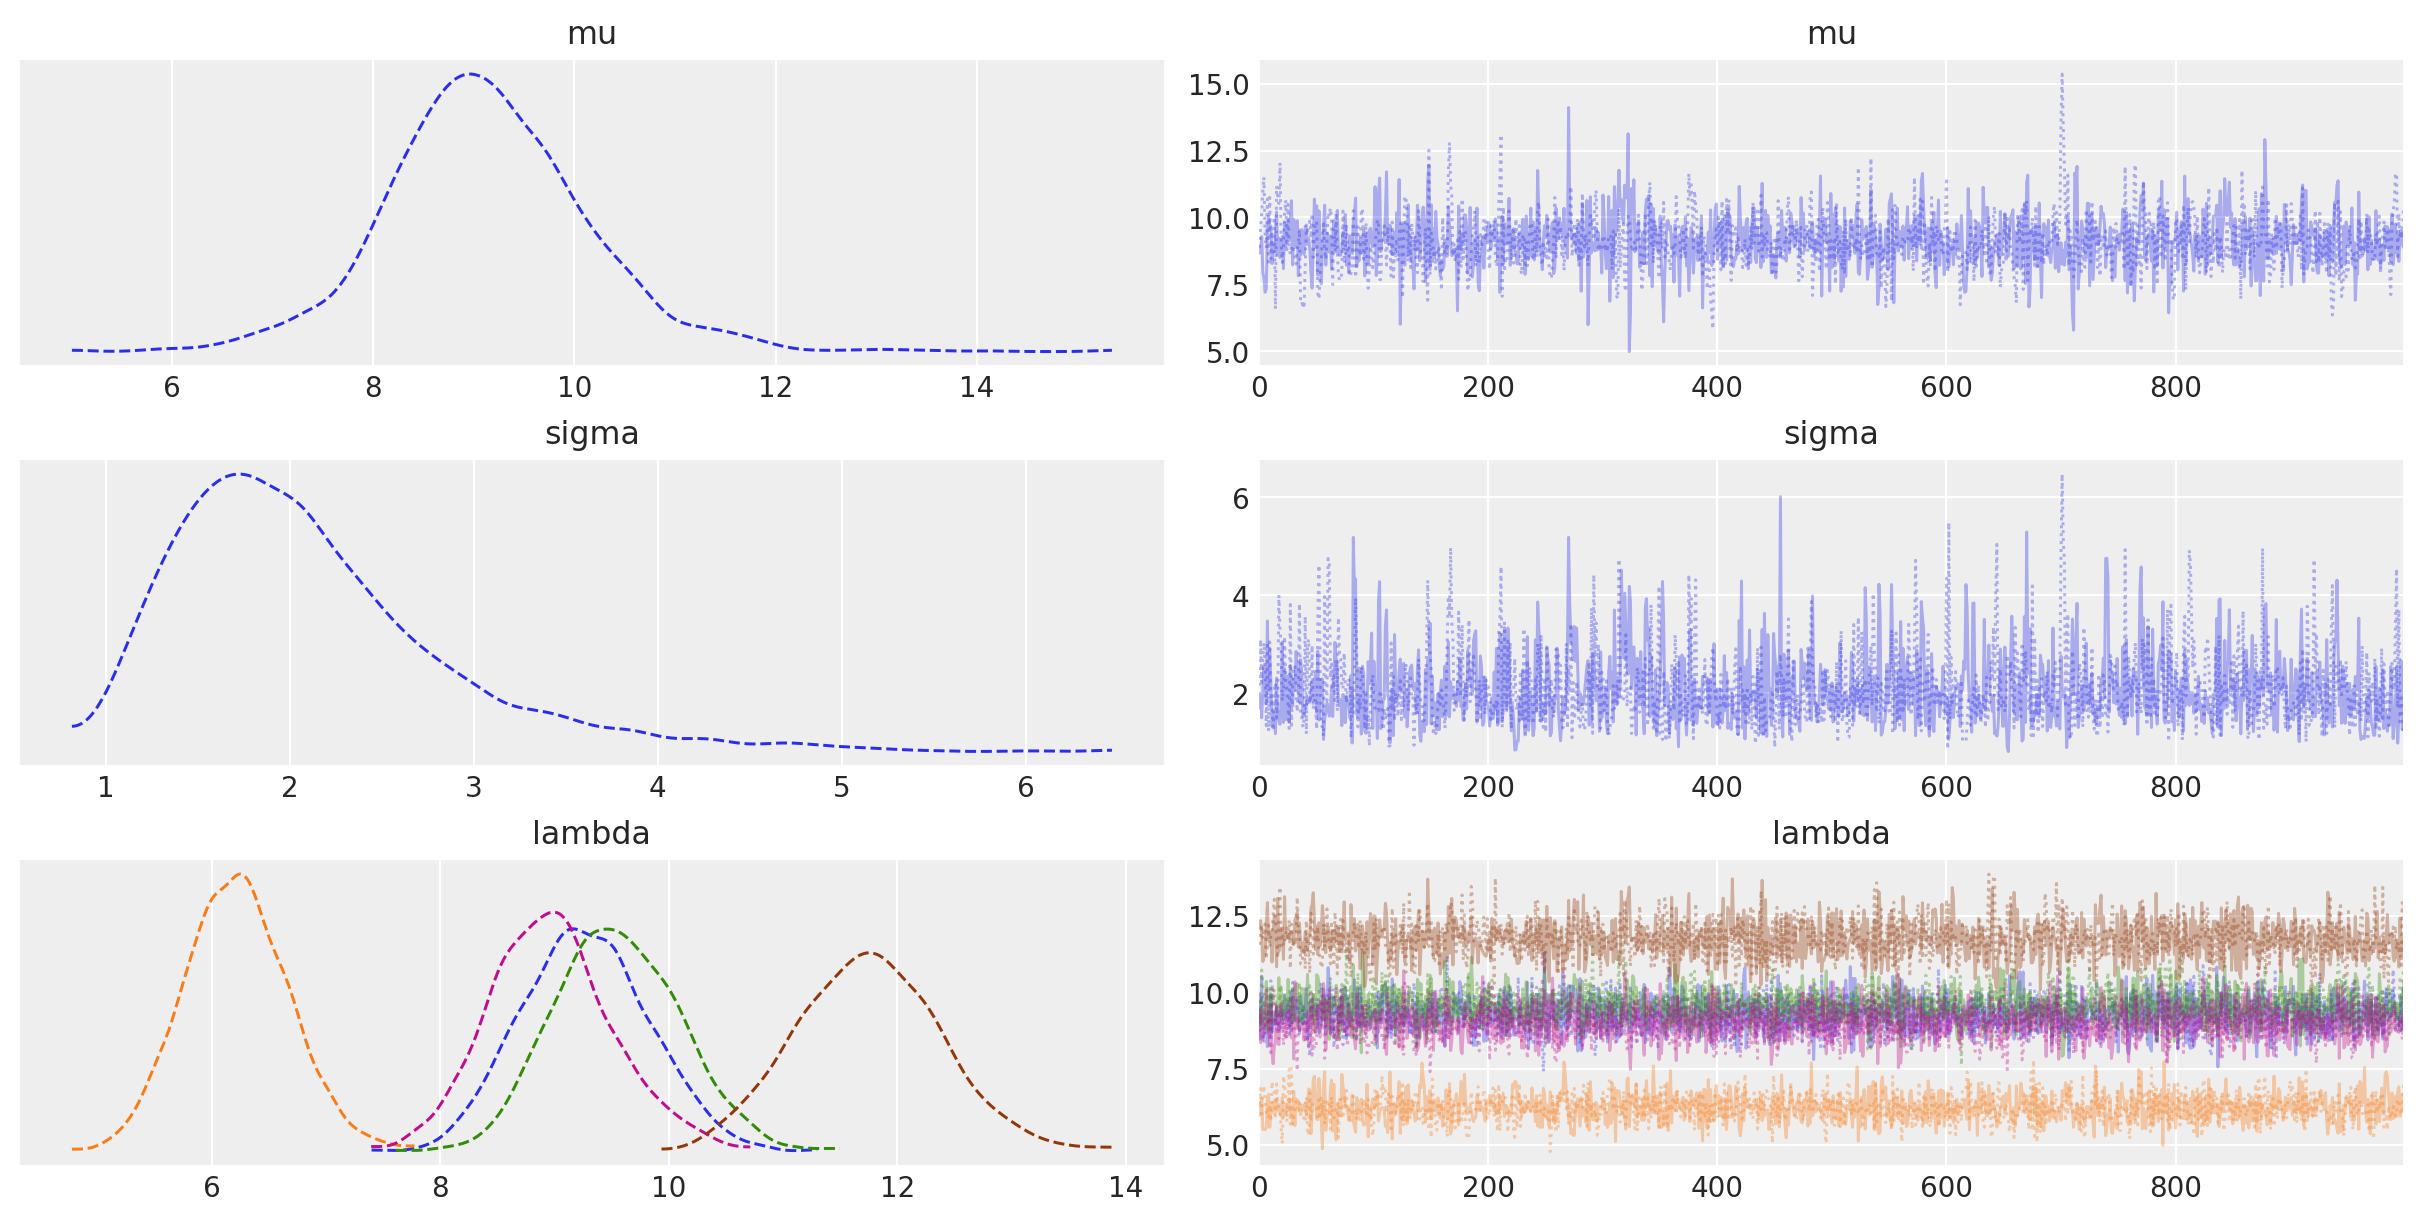

In [47]:
az.plot_trace(samples, combined=True);

In [49]:
az.summary(samples, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,9.115,1.006,7.202,11.008,0.028,0.020,1469.478,1191.615,1.000
sigma,2.092,0.750,1.008,3.535,0.022,0.016,1259.864,1280.812,1.000
lambda[0],9.266,0.548,8.187,10.220,0.011,0.008,2453.800,1554.260,1.000
lambda[1],6.221,0.456,5.397,7.083,0.011,0.008,1776.050,1492.061,0.999
lambda[2],9.546,0.545,8.576,10.591,0.011,0.008,2655.956,1588.138,1.000
lambda[3],8.966,0.540,8.040,10.099,0.011,0.008,2304.537,1534.646,1.003
lambda[4],11.750,0.629,10.577,12.946,0.014,0.010,1929.370,1675.070,1.000


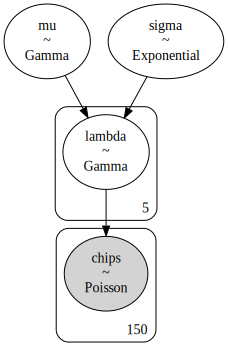

In [51]:
pm.model_to_graphviz(mod)

In [73]:
with mod:
    pm.sample_posterior_predictive(samples, extend_inferencedata=True)

Sampling: [chips]


In [74]:
samples

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

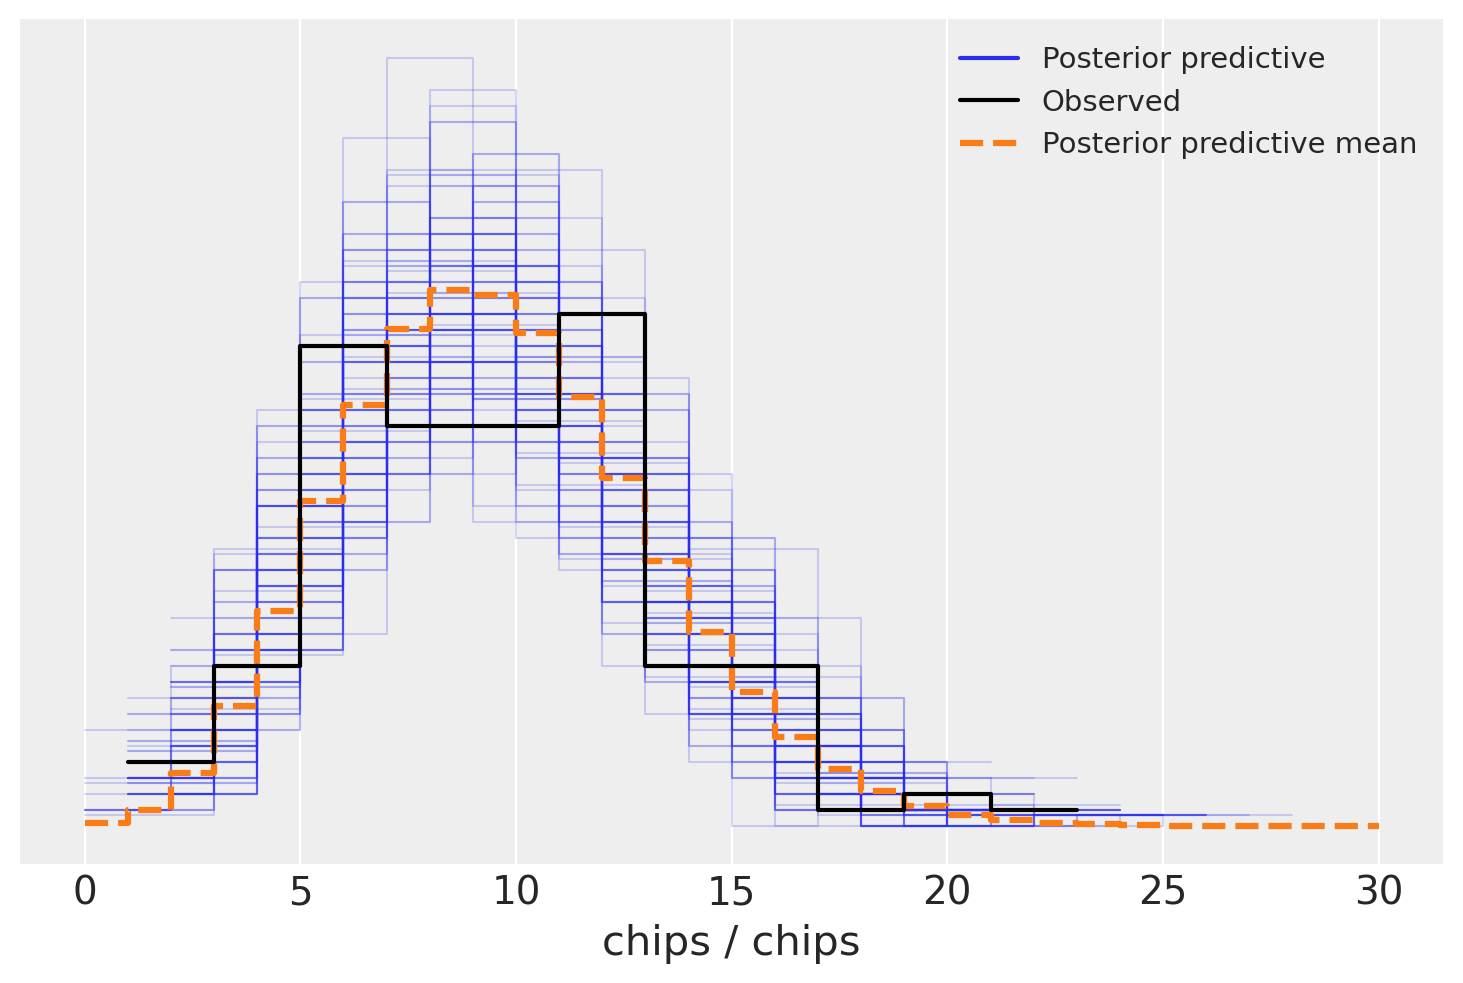

In [83]:
az.plot_ppc(samples, num_pp_samples=100)
plt.show()

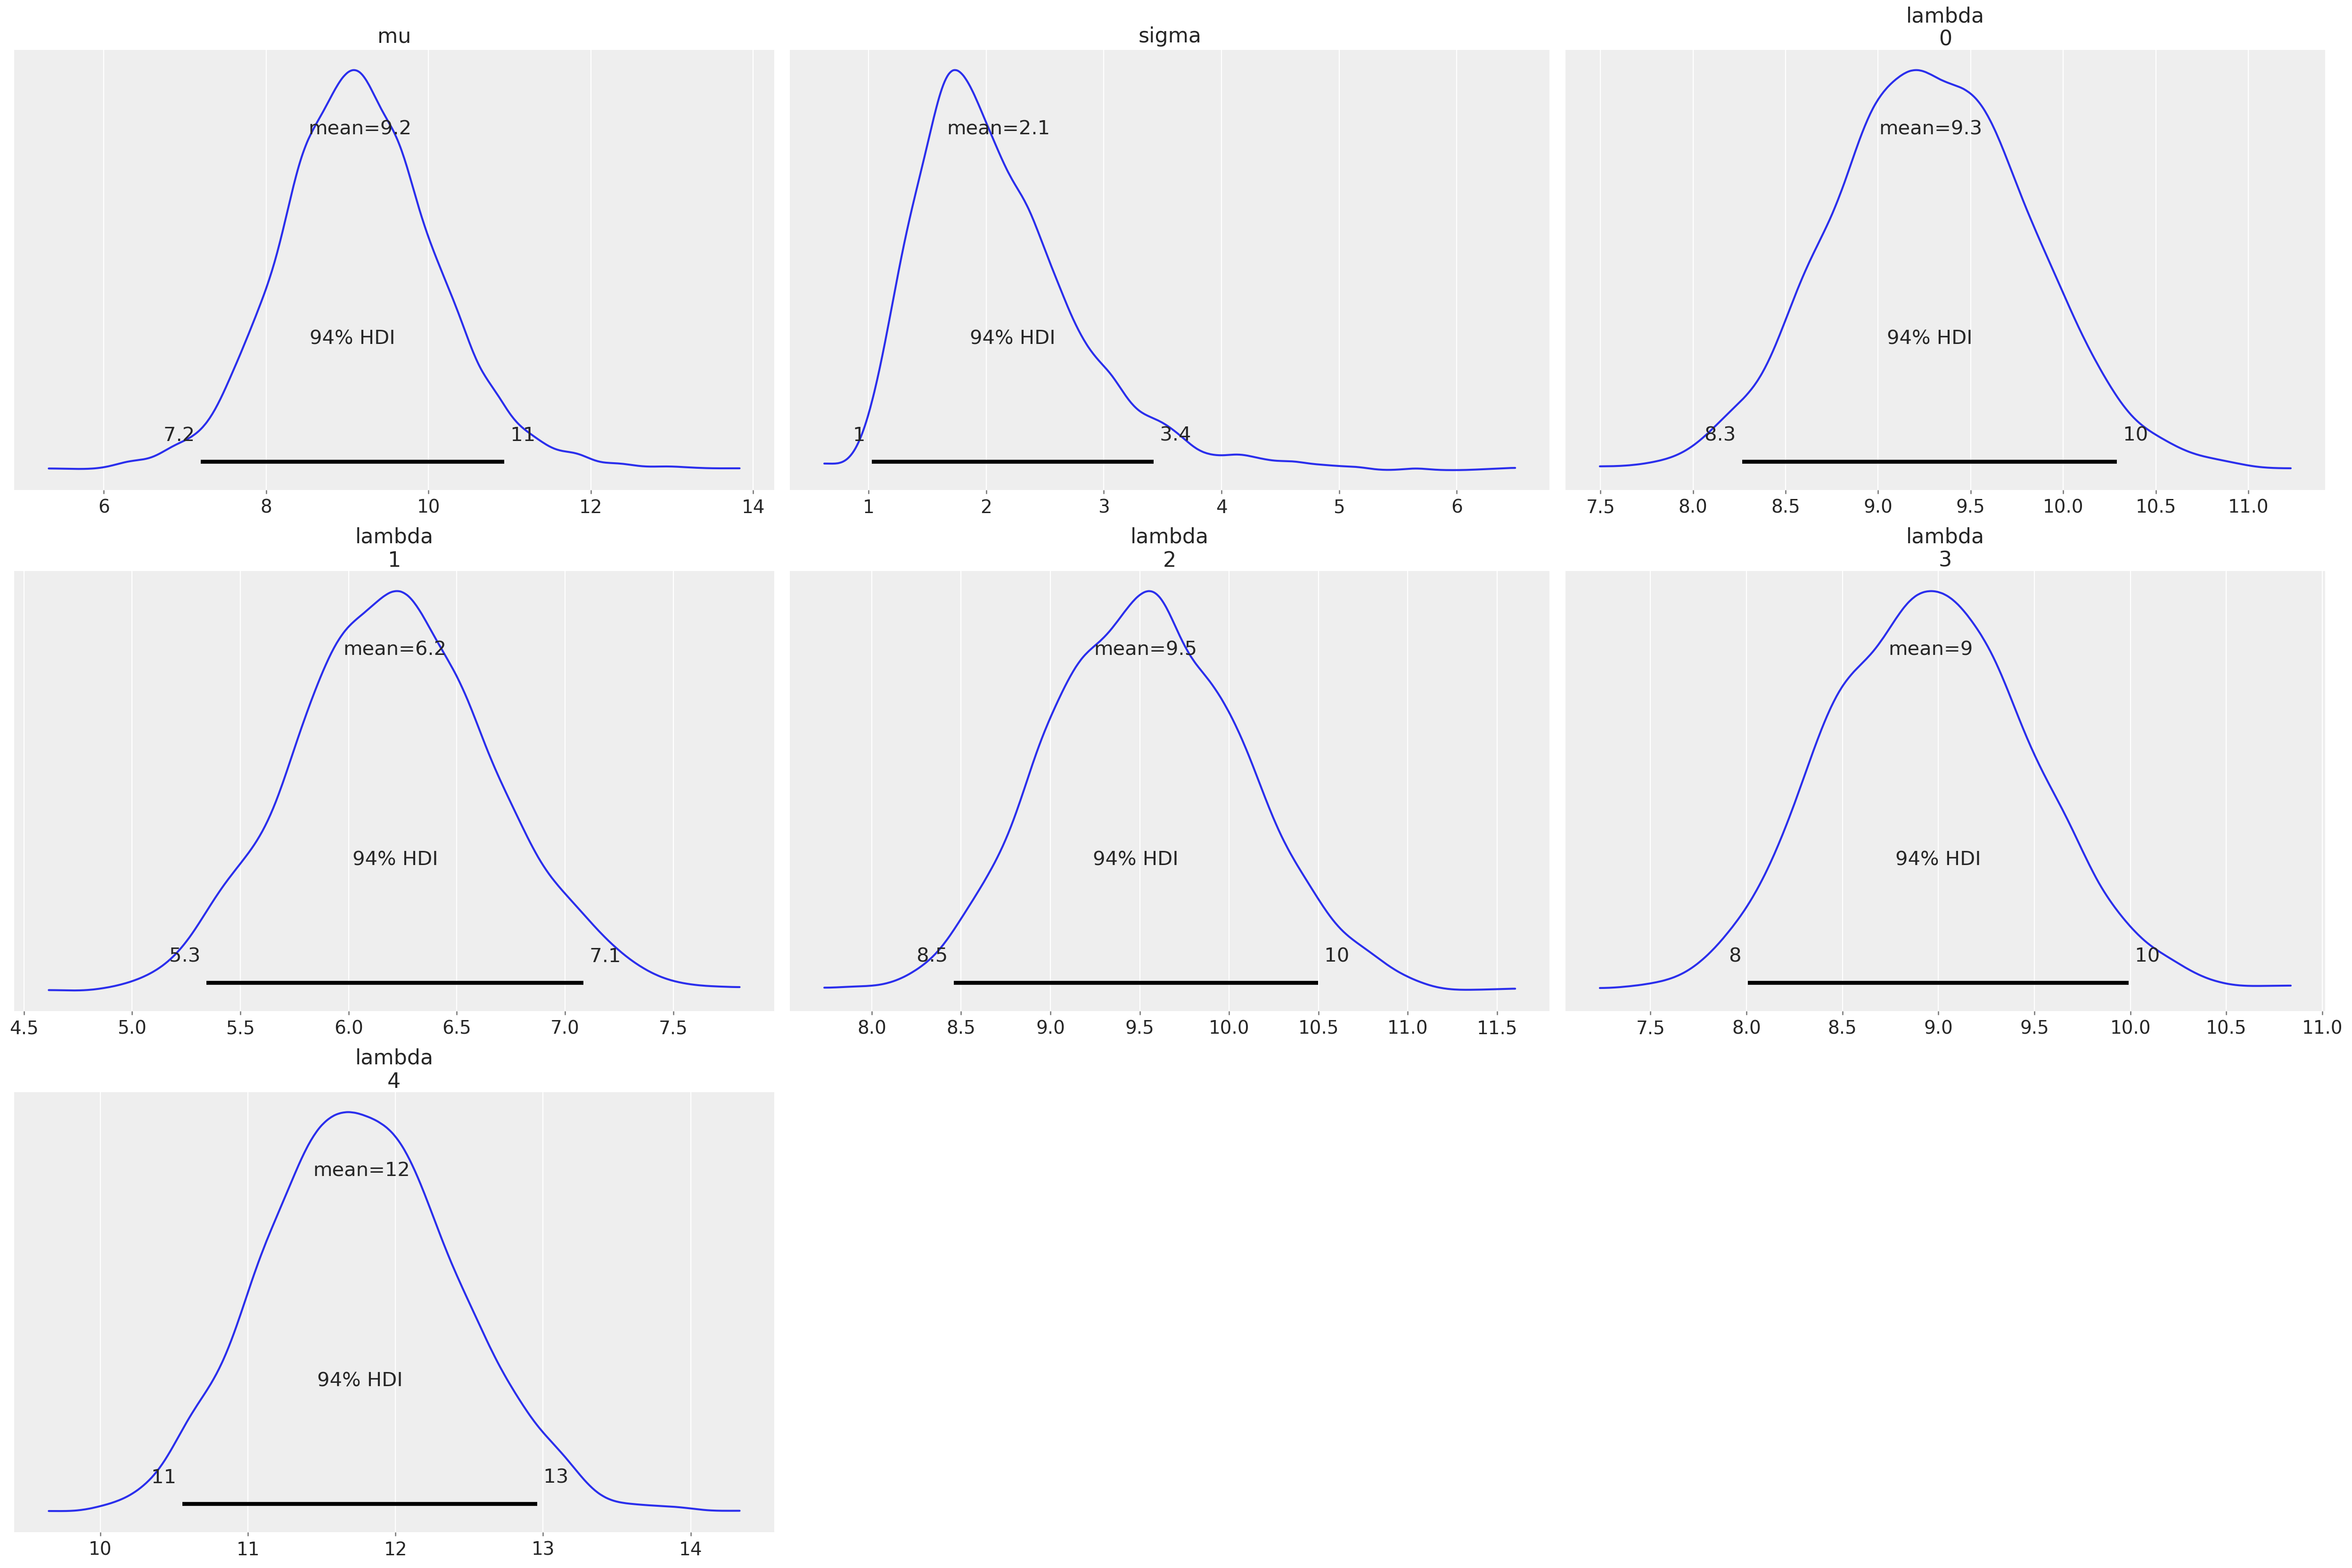

In [78]:
az.plot_posterior(samples)
plt.show()